# Projeto de aplicação do Active Learning

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
def eval_prioritization_strategy(prioritizer):
  train_indices = range(60000)

  test_accuracies = []
  x_train_subset = np.zeros([0, 28, 28])
  y_train_subset = np.empty([0,])

  for i in range(40):
    selected_indices = train_indices[0:500]
    train_indices = train_indices[500:]
    x_train_subset = np.concatenate((x_train_subset, x_train[selected_indices,...]))
    y_train_subset = np.concatenate((y_train_subset, y_train[selected_indices,...]))

    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train_subset, y_train_subset, epochs=5, verbose=0)
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    test_accuracies.append(accuracy)
    print('Training data size of %d => accuracy %f' % (x_train_subset.shape[0], accuracy))

    predictions = model.predict(x_train[train_indices,...])
    train_indices = prioritizer(train_indices, predictions)

  return test_accuracies

In [5]:
unprioritized_accuracies = eval_prioritization_strategy(lambda indices, pred: indices)

Training data size of 500 => accuracy 0.823900
1860/1860 [==============================] - 5s 2ms/step
Training data size of 1000 => accuracy 0.870700
1844/1844 [==============================] - 4s 2ms/step
Training data size of 1500 => accuracy 0.888300
1829/1829 [==============================] - 3s 2ms/step
Training data size of 2000 => accuracy 0.888800
1813/1813 [==============================] - 4s 2ms/step
Training data size of 2500 => accuracy 0.910600
1797/1797 [==============================] - 3s 2ms/step
Training data size of 3000 => accuracy 0.910500
1782/1782 [==============================] - 4s 2ms/step
Training data size of 3500 => accuracy 0.910100
1766/1766 [==============================] - 4s 2ms/step
Training data size of 4000 => accuracy 0.920000
1750/1750 [==============================] - 5s 3ms/step
Training data size of 4500 => accuracy 0.927200
1735/1735 [==============================] - 4s 2ms/step
Training data size of 5000 => accuracy 0.931400
1719/171

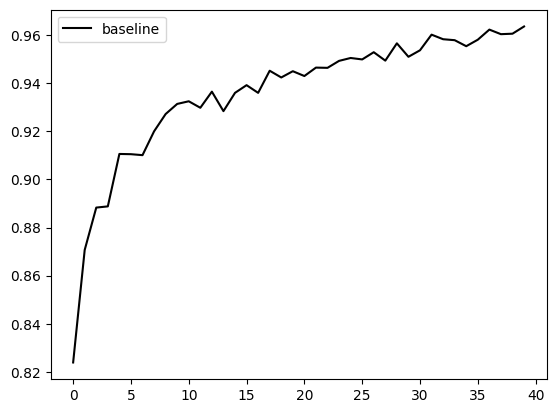

In [6]:
plt.plot(unprioritized_accuracies, 'k', label='baseline')
plt.legend()

In [7]:
def least_confidence_prediction_prioritizer(indices, predictions):
  max_logit = list(zip(indices, np.amax(predictions,axis=1)))
  max_logit.sort(key=lambda x: x[1]) # sort in ascending order
  return list(zip(*max_logit))[0]


In [8]:
least_confidence_accuracies = eval_prioritization_strategy(least_confidence_prediction_prioritizer)

Training data size of 500 => accuracy 0.821400
1860/1860 [==============================] - 5s 3ms/step
Training data size of 1000 => accuracy 0.856200
1844/1844 [==============================] - 4s 2ms/step
Training data size of 1500 => accuracy 0.895400
1829/1829 [==============================] - 5s 2ms/step
Training data size of 2000 => accuracy 0.906800
1813/1813 [==============================] - 3s 2ms/step
Training data size of 2500 => accuracy 0.926100
1797/1797 [==============================] - 3s 2ms/step
Training data size of 3000 => accuracy 0.933100
1782/1782 [==============================] - 4s 2ms/step
Training data size of 3500 => accuracy 0.944600
1766/1766 [==============================] - 3s 2ms/step
Training data size of 4000 => accuracy 0.951400
1750/1750 [==============================] - 3s 2ms/step
Training data size of 4500 => accuracy 0.955700
1735/1735 [==============================] - 4s 2ms/step
Training data size of 5000 => accuracy 0.953800
1719/171

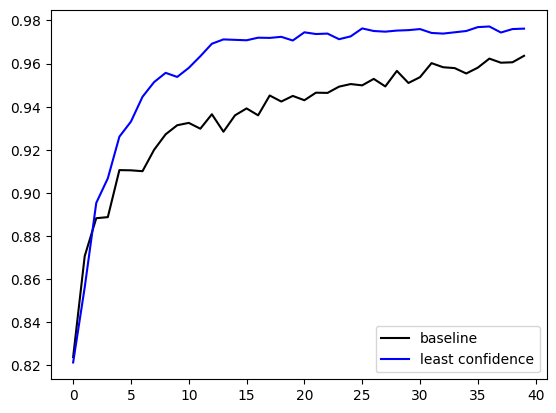

In [9]:
plt.plot(unprioritized_accuracies, 'k', label='baseline')
plt.plot(least_confidence_accuracies, 'b', label='least confidence')
plt.legend()

In [10]:
def entropy_prioritizer(indices, predictions):
  p = predictions * np.log(predictions)
  p = -p.sum(axis=1)
  p = list(zip(indices, p))
  p.sort(reverse=True, key=lambda x : x[1]) # sort in descending order
  return list(zip(*p))[0]

In [11]:
entropy_prioritized_accuracies = eval_prioritization_strategy(entropy_prioritizer)

Training data size of 500 => accuracy 0.825900
1860/1860 [==============================] - 7s 4ms/step
Training data size of 1000 => accuracy 0.845300
1844/1844 [==============================] - 3s 2ms/step
Training data size of 1500 => accuracy 0.882000
1829/1829 [==============================] - 3s 2ms/step
Training data size of 2000 => accuracy 0.902200
1813/1813 [==============================] - 4s 2ms/step
Training data size of 2500 => accuracy 0.919500
1797/1797 [==============================] - 3s 2ms/step
Training data size of 3000 => accuracy 0.922100
1782/1782 [==============================] - 3s 2ms/step
Training data size of 3500 => accuracy 0.935900
1766/1766 [==============================] - 4s 2ms/step
Training data size of 4000 => accuracy 0.938200
1750/1750 [==============================] - 3s 2ms/step
Training data size of 4500 => accuracy 0.948800
1735/1735 [==============================] - 3s 2ms/step
Training data size of 5000 => accuracy 0.954200
1719/171

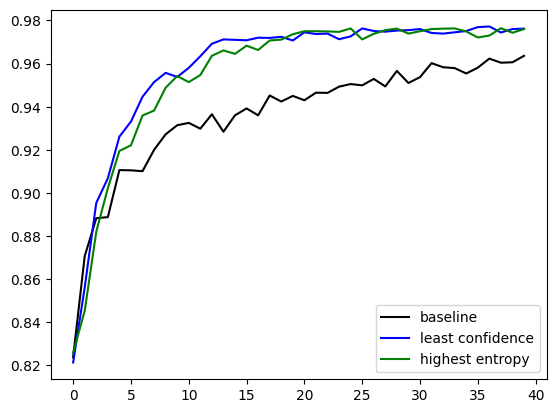

In [12]:
plt.plot(unprioritized_accuracies, 'k', label='baseline')
plt.plot(least_confidence_accuracies, 'b', label='least confidence')
plt.plot(entropy_prioritized_accuracies, 'g', label='highest entropy')
plt.legend()

In [13]:
def margin_prioritizer(indices, predictions):
  p = -np.sort(-predictions) # sort in descending order
  p = p[:,0] - p[:,1]
  p = list(zip(indices, p))
  p.sort(key=lambda x : x[1]) # sort in ascending order
  return list(zip(*p))[0]

In [14]:
margin_prioritized_accuracies = eval_prioritization_strategy(margin_prioritizer)

Training data size of 500 => accuracy 0.819800
1860/1860 [==============================] - 6s 3ms/step
Training data size of 1000 => accuracy 0.899300
1844/1844 [==============================] - 4s 2ms/step
Training data size of 1500 => accuracy 0.911900
1829/1829 [==============================] - 3s 2ms/step
Training data size of 2000 => accuracy 0.929800
1813/1813 [==============================] - 5s 3ms/step
Training data size of 2500 => accuracy 0.938300
1797/1797 [==============================] - 5s 3ms/step
Training data size of 3000 => accuracy 0.952000
1782/1782 [==============================] - 3s 2ms/step
Training data size of 3500 => accuracy 0.953300
1766/1766 [==============================] - 3s 2ms/step
Training data size of 4000 => accuracy 0.956500
1750/1750 [==============================] - 4s 3ms/step
Training data size of 4500 => accuracy 0.955500
1735/1735 [==============================] - 3s 2ms/step
Training data size of 5000 => accuracy 0.961700
1719/171

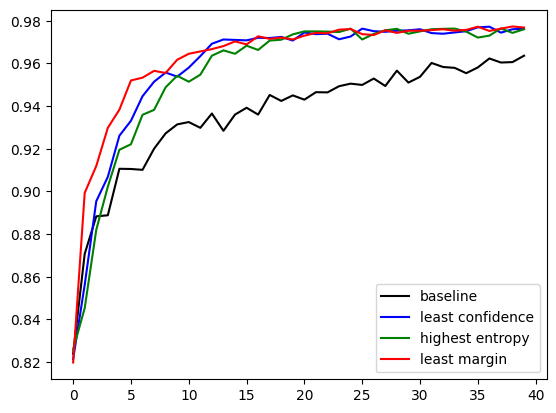

In [15]:
plt.plot(unprioritized_accuracies, 'k', label='baseline')
plt.plot(least_confidence_accuracies, 'b', label='least confidence')
plt.plot(entropy_prioritized_accuracies, 'g', label='highest entropy')
plt.plot(margin_prioritized_accuracies, 'r', label='least margin')
plt.legend()